<a href="https://colab.research.google.com/github/mrdbourke/m1-machine-learning-test/blob/main/00_cifar10_tinyvgg_benchmarkipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 TinyVGG Benchmark

The following notebook tests the speed at which a given device can perform training iterations on the [CIFAR10 dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data) (10 classes, 50,000 training images, 10,000 testing images) training the TinyVGG architecture as a base.

It's designed to be a simple test to compare Apple's M1 (normal, Pro, Max) to each other and other sources of compute.

| Model | Dataset | Train Size | Test Size |
| ----- | ----- | ----- | ----- |
| [TinyVGG](https://poloclub.github.io/cnn-explainer/) (trained from scratch) | CIFAR10 (from TensorFlow Datasets) | ~50,000 (32x32x3) images | ~10,000 (32x32x3) images|

## Resources
* Code on GitHub: https://github.com/mrdbourke/m1-machine-learning-test
* Code in this notebook adapted from: https://dev.mrdbourke.com/tensorflow-deep-learning/03_convolutional_neural_networks_in_tensorflow/

## Check for GPU

If you're using Google Colab, you'll need to activate a GPU:
1. Go to "Runtime"
2. Go to "Change Runtime Type"
3. Select "GPU"
4. Click "Save" (this will restart the runtime)

If you're using a Mac with an M1 chip, the GPU should already be selected if you've installed TensorFlow correctly.

In [1]:
# This will error if not using a Nvidia GPU (only works on Colab)
!nvidia-smi

Mon Nov 15 00:23:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    65W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Check for GPU using TensorFlow
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Setup hyperparameters

Change these to suit your needs.

The main one will be the device you're running code on.

E.g. `DEVICE = "Google Colab (K80 GPU)"` if using Google Colab.

In [3]:
# Setup hyperparameters
BATCH_SIZE = 32 # good for your health: https://twitter.com/ylecun/status/989610208497360896
EPOCHS = 10 # only run for a short period of time... we don't have all day
DATASET_NAME = "cifar10" # change this to try other image datasets from TensorFlow Datasets
DEVICE = "Google Colab (K80 GPU)" # change this depending on where you're runing the code

## Get helper functions and import dependencies

The function below downloads the helper functions if necessary (if running this notebook in Google Colab, it's easier to download a single file than clone the whole repo).

In [4]:
# Get helper functions
import os
import requests

if not os.path.exists("helper_functions.py"):
  print("Downloading helper functions...")
  r = requests.get("https://raw.githubusercontent.com/mrdbourke/m1-machine-learning-test/main/helper_functions.py")
  print("Writing helper functions to file...")
  open("helper_functions.py", "wb").write(r.content)
else:
  print("Helper functions already downloaded, skipping redownload.")

Helper functions already downloaded, skipping redownload.


In [5]:
# Check TensorFlow version
import tensorflow as tf
print(tf.__version__) # should be 2.5.0+

# Get TensorFlow Datasets
import tensorflow_datasets as tfds

# Get data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from timeit import default_timer as timer 
from helper_functions import print_train_time

2.7.0


## Get data from TensorFlow Keras Datasets

Let's download the data and inspect it. 

In [6]:
# Get data from tf.keras.datasets
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


  Image shape: (32, 32, 3)
  Image dtype: float64
  Target class from Food101: 6
  Class name (str form): frog
        


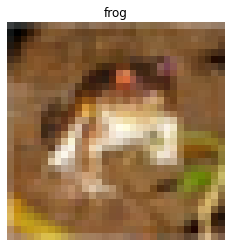

In [8]:
# Inspect image
image = train_images[0]
label = int(train_labels[0])

print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101: {label}
  Class name (str form): {class_names[label]}
        """)
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False);

## Prepare data

The data looks good. But before we model it, we're going to prepare it to run as fast as possible using [TensorFlow data loading best practices](https://www.tensorflow.org/guide/data_performance).

In [9]:
# Create datasets 
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Make datasets faster
train_data = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_data, test_data, len(train_data), len(test_data)

(<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 1)), types: (tf.float64, tf.uint8)>,
 <PrefetchDataset shapes: ((None, 32, 32, 3), (None, 1)), types: (tf.float64, tf.uint8)>,
 1563,
 313)

## Setup and fit model

To keep things simple, we're going to use the TinyVGG architecture from the [CNN explainer website](https://poloclub.github.io/cnn-explainer/).

In [10]:
# Set random seed
tf.random.set_seed(42)

# Start time
start_time = timer()

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(32, 32, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation="softmax") # multi-class activation output
], name="TinyVGG")

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # since labels aren't one-hot, use sparse_categorical_crossentropy
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit model 
history = model.fit(train_data,
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

# Track time 
end_time = timer()
train_time = print_train_time(start_time, 
                              end_time, 
                              device=DEVICE)

Epoch 1/10
1563/1563 [==============================] - 17s 7ms/step - loss: 1.7134 - accuracy: 0.3780 - val_loss: 1.5412 - val_accuracy: 0.4528
Epoch 2/10
1563/1563 [==============================] - 10s 7ms/step - loss: 1.4335 - accuracy: 0.4883 - val_loss: 1.4051 - val_accuracy: 0.5016
Epoch 3/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.3289 - accuracy: 0.5282 - val_loss: 1.2800 - val_accuracy: 0.5406
Epoch 4/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.2496 - accuracy: 0.5575 - val_loss: 1.2405 - val_accuracy: 0.5590
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1967 - accuracy: 0.5764 - val_loss: 1.2138 - val_accuracy: 0.5705
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.1566 - accuracy: 0.5905 - val_loss: 1.1849 - val_accuracy: 0.5810
Epoch 7/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.1246 - accuracy: 0.6025 - val_loss: 1.1616 - val_ac

## Track results and save to file

In [11]:
results = {
    "device": DEVICE,
    "dataset_name": DATASET_NAME,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "num_train_samples": len(train_data)*BATCH_SIZE,
    "num_test_samples": len(test_data)*BATCH_SIZE,
    "total_train_time": round(train_time, 3),
    "time_per_epoch": round(train_time/EPOCHS, 3),
    "model": model.name
    }
results_df = pd.DataFrame(results, index=[0])
results_df

,device,dataset_name,epochs,batch_size,num_train_samples,num_test_samples,total_train_time,time_per_epoch,model
0,Google Colab (K80 GPU),cifar10,10,32,50016,10016,166.911,16.691,TinyVGG


In [12]:
# Write CSV to file
if not os.path.exists("results/"):
  os.makedirs("results/")

results_df.to_csv(f"results/{DEVICE}_{DATASET_NAME}")